In [1]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from lmfit import Parameter, Parameters, Minimizer

import lmfit

from itertools import product

from mixcoatl.sourceGridTask import SourceGridTask

SyntaxError: invalid syntax (sourceGridTask.py, line 170)

In [1]:
infiles = glob.glob('/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6861D_long/catalogs/*.cat')
infile = infiles[0]

NameError: name 'glob' is not defined

In [3]:
grid_task = SourceGridTask()
grid_task.config.brute_search = True

grid = grid_task.run(infile)

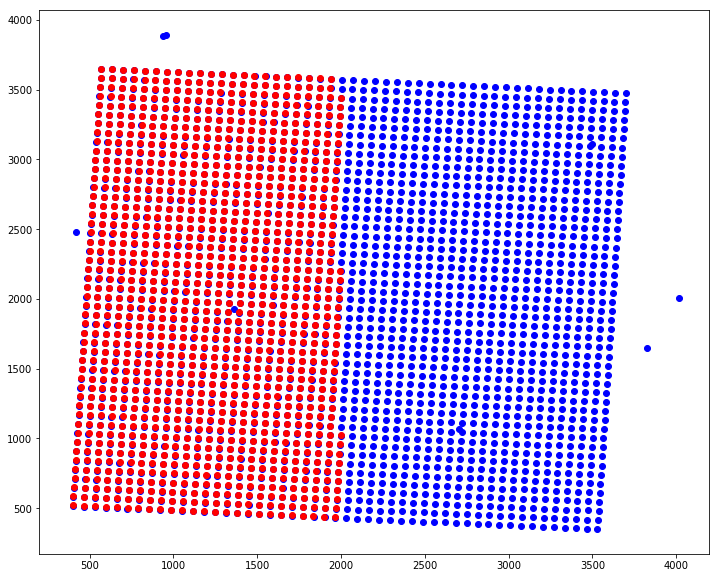

In [19]:
gY = grid['Y']
gX = grid['X']

ymin = 0
ymax = 4000
xmin = 0 
xmax = 2000

mask = (gY < ymax)*(gX < xmax)
gY = gY[mask]
gX = gX[mask]

src = fits.getdata(infile)
srcY = src['base_SdssShape_Y']
srcX = src['base_SdssShape_X']

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.scatter(srcX, srcY, color='blue')
ax.scatter(gX, gY, color='red')

In [7]:
from ctisim import ITL_AMP_GEOM

In [16]:
print(ITL_AMP_GEOM.nx*8)

4072


# Archive

In [ ]:
## Input
y0_guess = 2000.
x0_guess = 2000.
ncols = nrows = 49
distortions = None

## Module Code
src = fits.getdata(infile)

## Get source positions
srcY = src['base_SdssShape_X']
srcX = src['base_SdssShape_Y']

## Curate data here (remove bad shapes, fluxes, etc.)
srcW = np.sqrt(np.square(src['base_SdssShape_XX']) + np.square(src['base_SdssShape_YY']))
mask = (srcW > 4.)

srcY = src['base_SdssShape_X'][mask]
srcX = src['base_SdssShape_Y'][mask]

## Construct mask
nsources = srcY.shape[0]
indices, distances = coordinate_distances(srcY, srcX, srcY, srcX)
nn_indices = indices[:, 1:5]
nn_distances = distances[:, 1:5]
med_dist = np.median(nn_distances)

dist1_array = np.full(nsources, np.nan)
dist2_array = np.full(nsources, np.nan)
theta_array = np.full(nsources, np.nan)

for i in range(nsources):

    yc = srcY[i]
    xc = srcX[i]

    for j in range(4):

        nn_dist = nn_distances[i, j]
        if np.abs(nn_dist - med_dist) > 10.: continue
        y_nn = srcY[nn_indices[i, j]]
        x_nn = srcX[nn_indices[i, j]]

        if x_nn > xc:
            if y_nn > yc:
                dist1_array[i] = nn_dist
                theta_array[i] = np.arctan((y_nn-yc)/(x_nn-xc))
            else:
                dist2_array[i] = nn_dist

theta = np.nanmedian(theta_array)
if theta >= np.pi/4.:
    theta = theta - (np.pi/2.)
    xstep = np.nanmedian(dist2_array)
    ystep = np.nanmedian(dist1_array)
else:
    xstep = np.nanmedian(dist1_array)
    ystep = np.nanmedian(dist2_array)
    
print(theta)

## Perform Fit
params = Parameters()
params.add('ystep', value=ystep, vary=False)
params.add('xstep', value=xstep, vary=False)
params.add('theta', value=theta, vary=False)
params.add('y0', value=y0_guess, min=y0_guess-ystep, max=y0_guess+ystep, vary=True, brute_step=ystep/4.)
params.add('x0', value=x0_guess, min=x0_guess-xstep, max=x0_guess+xstep, vary=True, brute_step=xstep/4.)

print(params.valuesdict)

minner = Minimizer(fit_error, params, fcn_args=(srcY, srcX, ncols, nrows, distortions))
result = minner.minimize(method='brute', params=params)

params = result.params
params['theta'].set(vary=True)

minner = Minimizer(fit_error, params, fcn_args=(srcY, srcX, ncols, nrows, distortions))
result = minner.minimize(params=params)